# Feature Expansion - Polynomials

## 1) Warmup

Which types of feature engineering have you seen last week?

- Imputation (filling in missing values)
    - Mean
    - Group Mean
- One-hot-encoding / Dummy-Variables
- Scaling
    - MaxMin
    - Standard
- Binning
    - cut
    - qcut
- Log-transformation
- Take out outliers
- Label-encoding
    - pd.factorize() --> transform categorical strings into integers
- Map values

## 2) Are those all possibilities?

No.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (12,6)

## 2.1) Polynomials

Sum of powers of x, multiplied by some coefficient

$$
a_0 * x^0 + a_1 * x^1 + a_2 * x^2 + ...
$$

In [16]:
# Load the Anscombe dataset
df = sns.load_dataset('anscombe')
df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


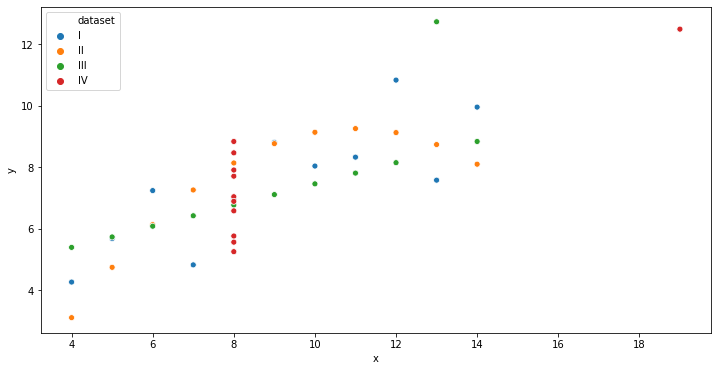

In [17]:
# Visualize the dataset
sns.scatterplot(x='x', y='y', data=df, hue='dataset')

In [19]:
# Creating a filter
dataset2 = df['dataset'] == 'II'

In [26]:
# Applying the filter
df[dataset2]

# Equivalently
# df[df['dataset']=='II']

,dataset,x,y
11,II,10.0,9.14
12,II,8.0,8.14
13,II,13.0,8.74
14,II,9.0,8.77
15,II,11.0,9.26
16,II,14.0,8.10
17,II,6.0,6.13
18,II,4.0,3.10
19,II,12.0,9.13
20,II,7.0,7.26


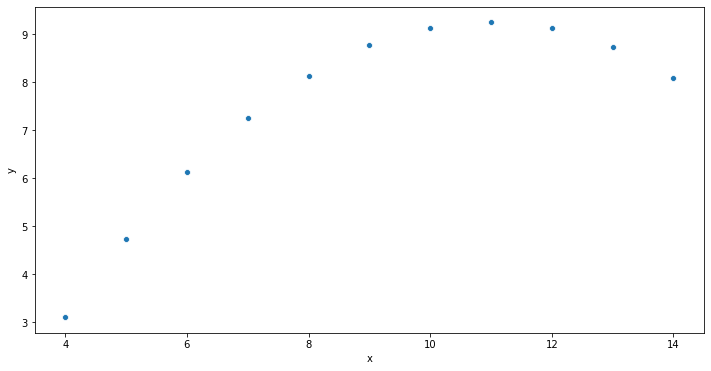

In [25]:
# Visualize dataset II
sns.scatterplot(x='x', y='y', data=df[dataset2])

In [27]:
# Create X and y
X = df[dataset2][['x']]
X

,x
11,10.0
12,8.0
13,13.0
14,9.0
15,11.0
16,14.0
17,6.0
18,4.0
19,12.0
20,7.0


In [28]:
y = df[dataset2]['y']
y

11    9.14
12    8.14
13    8.74
14    8.77
15    9.26
16    8.10
17    6.13
18    3.10
19    9.13
20    7.26
21    4.74
Name: y, dtype: float64

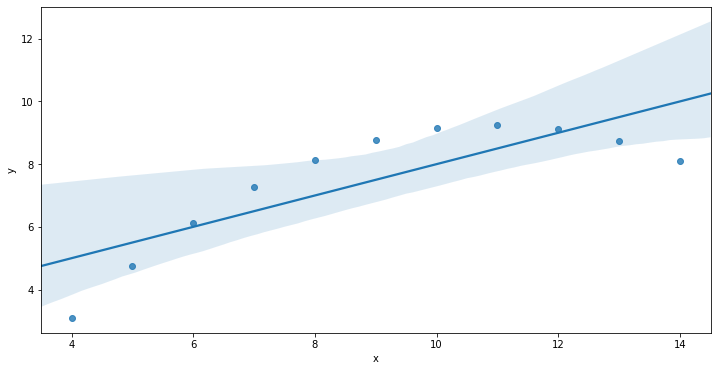

In [29]:
# Plot the regression
sns.regplot(x='x', y='y', data=df[dataset2])

In [31]:
# Instead define a Polynomial
X['x^2'] = X['x']**2
X

,x,x^2
11,10.0,100.0
12,8.0,64.0
13,13.0,169.0
14,9.0,81.0
15,11.0,121.0
16,14.0,196.0
17,6.0,36.0
18,4.0,16.0
19,12.0,144.0
20,7.0,49.0


Polynomial in this case would be $b + w_1 * x^1 + w_2 * x^2$

In [32]:
# Fit the model
from sklearn.linear_model import LinearRegression
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [33]:
# Plot the result
ypred = m.predict(X)

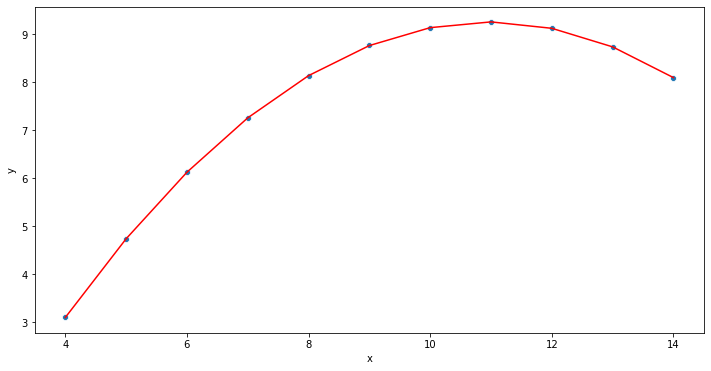

In [37]:
sns.scatterplot(x=X['x'], y=y)
sns.lineplot(x=X['x'], y=ypred, color='r')

In [38]:
# Show PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

In [44]:
# Create a polynomial feature transformer
polynomial_transformer = PolynomialFeatures(degree=3, include_bias=False)

In [46]:
polynomial_features = polynomial_transformer.fit_transform(df[dataset2][['x']])
polynomial_features

array([[  10.,  100., 1000.],
       [   8.,   64.,  512.],
       [  13.,  169., 2197.],
       [   9.,   81.,  729.],
       [  11.,  121., 1331.],
       [  14.,  196., 2744.],
       [   6.,   36.,  216.],
       [   4.,   16.,   64.],
       [  12.,  144., 1728.],
       [   7.,   49.,  343.],
       [   5.,   25.,  125.]])

In [47]:
m.fit(polynomial_features, y)

LinearRegression()

In [51]:
# Add the names to the columns
pd.DataFrame(polynomial_features, columns=polynomial_transformer.get_feature_names())

,x0,x0^2,x0^3
0,10.0,100.0,1000.0
1,8.0,64.0,512.0
2,13.0,169.0,2197.0
3,9.0,81.0,729.0
4,11.0,121.0,1331.0
5,14.0,196.0,2744.0
6,6.0,36.0,216.0
7,4.0,16.0,64.0
8,12.0,144.0,1728.0
9,7.0,49.0,343.0


### 2.2) Complex function

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [59]:
np.random.seed(0)
n_samples = 30

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

In [60]:
# create an x-array
X = np.sort(np.random.rand(n_samples))

# create an array of y-observations
y_train = true_fun(X) + np.random.randn(n_samples) * 0.1

# create the true y
y_true = true_fun(X)

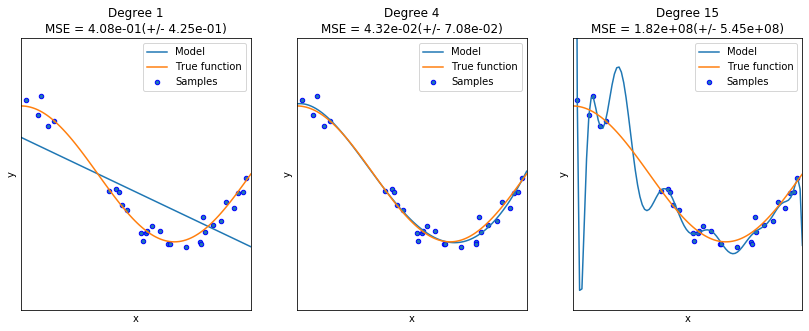

In [61]:
# Define the number of degrees that should be included
degrees = [1, 4, 15]

# Write a for loop that fit_transforms the model for all the different number of degrees
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    # Make a pipeline
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y_train)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y_train,
                             scoring="neg_mean_squared_error", cv=10)
    
    # Actually plot the function
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y_train, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()